In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def imageProcessing(image_path = '/highway.png'):
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  highlighted_image = np.copy(image_rgb)
  hsv_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  #For defining range for white color in hsv i am using high value and low saturation.
  lower_white = np.array([0,0,200])
  upper_white = np.array([180,30,255])
  lower_yellow = np.array([20,100,100])
  upper_yellow = np.array([30,255,255])
  #creating mask
  white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
  yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
  #combining masks to get all lane markings
  combined_mask = cv2.bitwise_or(white_mask, yellow_mask)
  blurred_mask = cv2.GaussianBlur(combined_mask,(5,5),0)
  edges = cv2.Canny(blurred_mask, 50, 150)
  #Defining region of interest
  height, width = edges.shape
  roi_vertices = np.array([
        [(0, height), (0, height/2), (width, height/2), (width, height)]
    ], dtype=np.int32)
  #creating and applying ROI mask
  roi_mask = np.zeros_like(edges)
  cv2.fillPoly(roi_mask, roi_vertices, 255)
  masked_edges = cv2.bitwise_and(edges, roi_mask)
  #applying Hough line tranform
  lines = cv2.HoughLinesP(
      masked_edges,
      rho = 1,
      theta = np.pi/180,
      threshold = 20,
      minLineLength = 20,
      maxLineGap = 300
  )
  line_mask = np.zeros_like(image_rgb)
  #to draw detected lines on the line mask
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(line_mask, (x1, y1), (x2, y2), (255, 0, 0), 5)
  #combining the line mask with original image
  alpha = 0.8
  beta = 1.0
  gamma = 0
  highlighted_image = cv2.addWeighted(highlighted_image, alpha, line_mask, beta, gamma)
  #preparing colored masks
  white_mask_colored = np.zeros_like(image_rgb)
  white_mask_colored[white_mask > 0] = [255, 255, 255]
  yellow_mask_colored = np.zeros_like(image_rgb)
  yellow_mask_colored[yellow_mask > 0] = [255, 255, 0]

  #applying morphological operations
  kernel = np.ones((5,5), np.uint8)
  white_mask_cleaned = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)
  yellow_mask_cleaned = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel)

  white_mask_final = np.zeros_like(image_rgb)
  white_mask_final[white_mask_cleaned > 0] = [255, 255, 255]

  yellow_mask_final = np.zeros_like(image_rgb)
  yellow_mask_final[yellow_mask_cleaned > 0] = [255, 255, 0]

  final_mask = cv2.bitwise_or(white_mask_final, yellow_mask_final)
  final_highlighted = cv2.addWeighted(image_rgb, 0.8, final_mask, 0.7, 0)
  return{
      'original': image_rgb,
      'highlighted': final_highlighted,
      'white_mask': white_mask_final,
      'yellow_mask': yellow_mask_final,
      'white_mask_binary': white_mask_cleaned,
      'yellow_mask_binary': yellow_mask_cleaned
  }


In [18]:
def display_results(results):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(results['original'])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(results['highlighted'])
    plt.title('Highlighted Lane Markings')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(results['white_mask_binary'], cv2.COLOR_GRAY2RGB))
    plt.title('White Lane Mask (Binary)')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(results['yellow_mask_binary'], cv2.COLOR_GRAY2RGB))
    plt.title('Yellow Lane Mask (Binary)')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(results['white_mask'])
    plt.title('White Lane Mask (Colored)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(results['yellow_mask'])
    plt.title('Yellow Lane Mask (Colored)')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('lane_detection_results.png')
    plt.show()

In [19]:
def save_results(results, output_dir='./'):
    # Saving the highlighted image
    plt.imsave(f'{output_dir}highlighted_lanes.png', results['highlighted'])

    # Saving the white lane mask
    plt.imsave(f'{output_dir}white_lane_mask.png', cv2.cvtColor(results['white_mask_binary'], cv2.COLOR_GRAY2RGB))

    # Saving the yellow lane mask
    plt.imsave(f'{output_dir}yellow_lane_mask.png', cv2.cvtColor(results['yellow_mask_binary'], cv2.COLOR_GRAY2RGB))

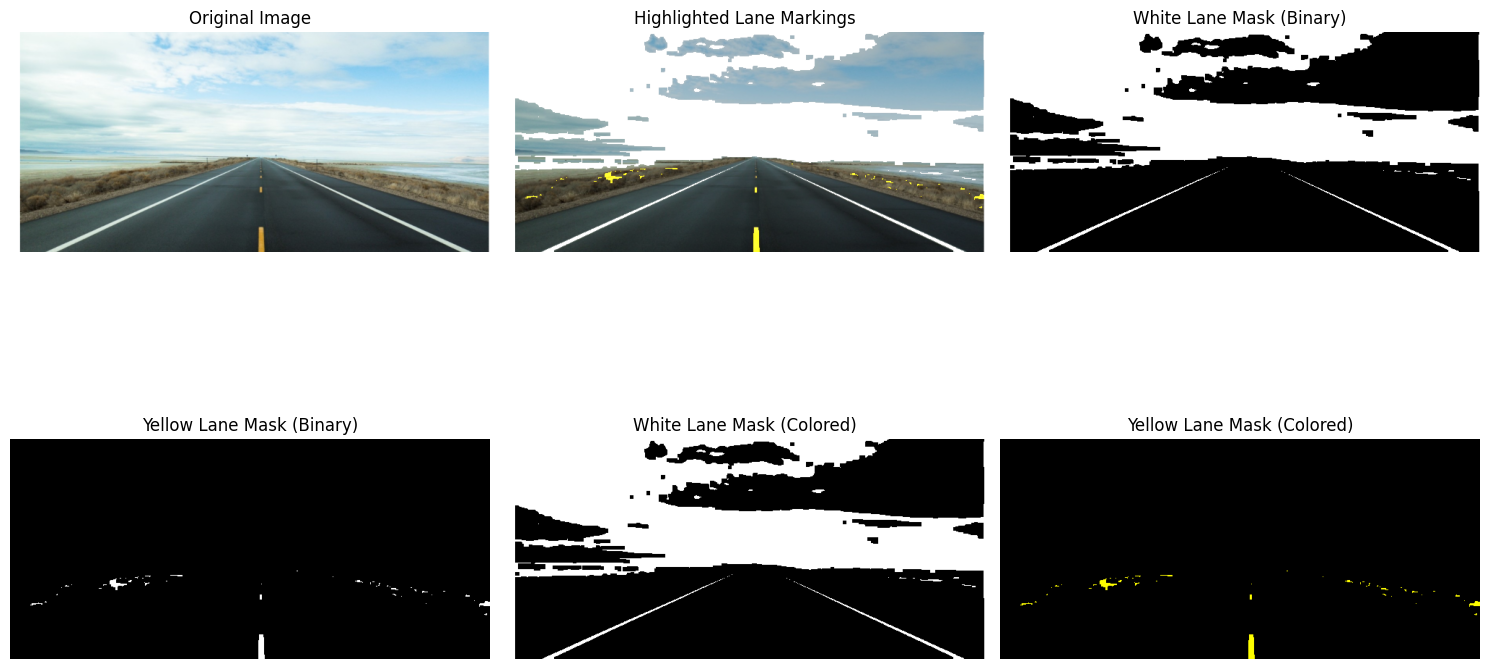

In [20]:
if __name__ == "__main__":
  image_path = '/highway.png'
  results = imageProcessing(image_path)
  display_results(results)
  save_results(results)